In [1]:
import matplotlib.pyplot as plt
import os
import glob
import netCDF4 as nc
import numpy as np
from salishsea_tools import places, geo_tools

from nowcast.figures import shared

%matplotlib inline

In [2]:
grid = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
X = grid.variables['nav_lon'][:]
Y = grid.variables['nav_lat'][:]
bathy = grid.variables['Bathymetry'][:]
mesh_mask = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_SalishSea2.nc')

## Base

In [3]:
path='/ocean/nsoontie/MEOPAR/SalishSea/results/mixing_paper/base_spinup/'
base_subdirs = ['13sep2014_13dec2014', '14dec2014_22jan2015', '23jan2015_03mar2015',
                '04mar2015_05jun2015', '06jun2015_07jul2015', '08jul2015', '09jul2015_17aug2015']

stations = ['Central node', 'East node']

In [4]:
sal_base = {}
time_base = {}
for station in stations:
    lon = places.PLACES[station]['lon lat'][0]
    lat = places.PLACES[station]['lon lat'][1]
    j, i = geo_tools.find_closest_model_point(lon,lat,X,Y, land_mask=bathy.mask)
    depth = places.PLACES[station]['depth']    
    model_depths = mesh_mask.variables['gdept'][0,:,j,i]
    tmask = mesh_mask.variables['tmask'][0,:,j,i]
    wdeps = mesh_mask.variables['gdepw'][0,:,j,i]
    sal_array = np.array([])
    time_array = np.array([])
    for subdir in base_subdirs:
        fname = glob.glob(os.path.join(path, subdir, 'SalishSea_*_grid_T.nc'))[0]
        f = nc.Dataset(fname)
        sal = f.variables['vosaline'][:,:,j,i]
        sal_interp = np.array([shared.interpolate_tracer_to_depths(sal[t,:],model_depths,depth,tmask,wdeps) 
                               for t in range(sal.shape[0])])
        tc = f.variables['time_counter']
        time = nc.num2date(tc[:], tc.units)
        sal_array = np.concatenate((sal_array, sal_interp))
        time_array = np.concatenate((time_array, time))
    sal_base[station] = sal_array
    time_base[station] = time_array

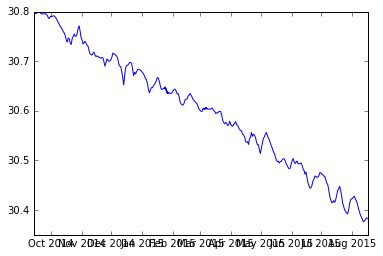

In [5]:
station='Central node' 
plt.plot(time_base[station], sal_base[station])

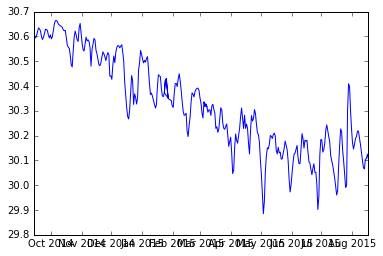

In [6]:
station='East node' 
plt.plot(time_base[station], sal_base[station])

## Holl Spinup

In [7]:
path='/ocean/nsoontie/MEOPAR/SalishSea/results/mixing_paper/holl_spinup/'
holl_subdirs = ['13sep2014_13dec2014', '14dec2014_22jan2015', '23jan2015_26apr2015',
                '27apr2015_07jul2015', '08jul2015', '09jul2015_17aug2015']


In [8]:
sal_holl = {}
time_holl = {}
for station in stations:
    lon = places.PLACES[station]['lon lat'][0]
    lat = places.PLACES[station]['lon lat'][1]
    j, i = geo_tools.find_closest_model_point(lon,lat,X,Y, land_mask=bathy.mask)
    depth = places.PLACES[station]['depth']    
    model_depths = mesh_mask.variables['gdept'][0,:,j,i]
    tmask = mesh_mask.variables['tmask'][0,:,j,i]
    wdeps = mesh_mask.variables['gdepw'][0,:,j,i]
    sal_array = np.array([])
    time_array = np.array([])
    for subdir in holl_subdirs:
        fname = glob.glob(os.path.join(path, subdir, 'SalishSea_*_grid_T.nc'))[0]
        f = nc.Dataset(fname)
        sal = f.variables['vosaline'][:,:,j,i]
        sal_interp = np.array([shared.interpolate_tracer_to_depths(sal[t,:],model_depths,depth,tmask,wdeps) 
                               for t in range(sal.shape[0])])
        tc = f.variables['time_counter']
        time = nc.num2date(tc[:], tc.units)
        sal_array = np.concatenate((sal_array, sal_interp))
        time_array = np.concatenate((time_array, time))
    sal_holl[station] = sal_array
    time_holl[station] = time_array

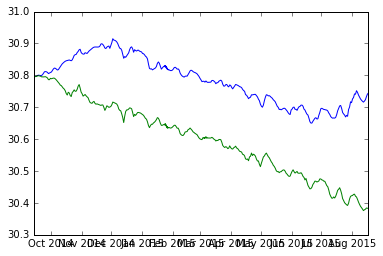

In [9]:
station='Central node' 
plt.plot(time_holl[station], sal_holl[station])
plt.plot(time_base[station], sal_base[station])

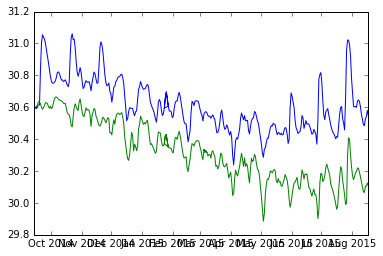

In [10]:
station='East node' 
plt.plot(time_holl[station], sal_holl[station])
plt.plot(time_base[station], sal_base[station])

In [11]:
def resample_daily_obs(obs):
    obs_new=obs
    obs_new[['sal','temp']]=obs_new[['sal','temp']].astype(float)
    obs_new['date_index'] = pd.DatetimeIndex(obs_new['date'])
    obs_new.set_index('date_index', inplace=True)
    
    obs_new = obs_new.resample('D', how='mean')
    obs_new = obs_new.reset_index()
    obs_new = obs_new.rename(columns=({'date_index':'date'}))
    return obs_new

In [19]:
from nowcast.figures import research_VENUS
import pandas as pd
from salishsea_tools import teos_tools
import datetime

In [17]:
East = research_VENUS.load_VENUS('East')
Central = research_VENUS.load_VENUS('Central')

East_daily = resample_daily_obs(East)
Central_daily = resample_daily_obs(Central)

/home/nsoontie/anaconda3/envs/mixing_paper/lib/python3.5/site-packages/ipykernel/__main__.py:7: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()


In [18]:
import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')
sns.set_color_codes()

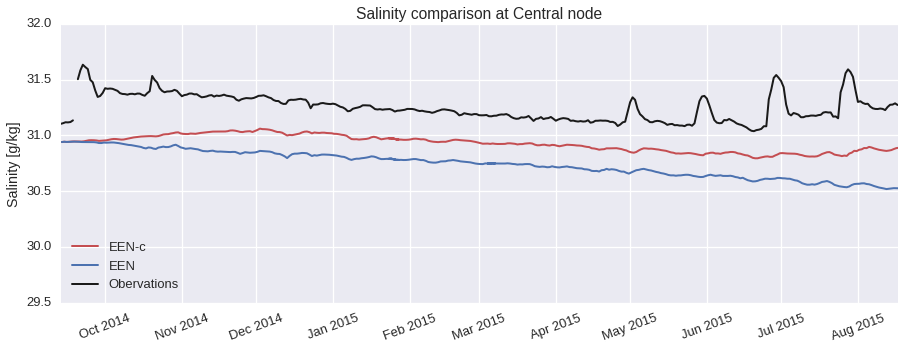

In [25]:
station='Central node' 
fig,ax=plt.subplots(1,1,figsize= (15,5))
ax.plot(time_holl[station], teos_tools.psu_teos(sal_holl[station]), color='r', label='EEN-c',lw=2)
ax.plot(time_base[station], teos_tools.psu_teos(sal_base[station]), color='b', label='EEN', lw=2)
ax.plot(Central_daily.date[:], teos_tools.psu_teos(Central_daily['sal'][:]), color='k', label='Obervations', lw=2)
ax.set_xlim(datetime.datetime(2014,9,13),datetime.datetime(2015,8,17))
ax.set_ylabel('Salinity [g/kg]')
plt.setp( ax.xaxis.get_majorticklabels(), rotation=20)
ax.legend(loc=0)
ax.set_title('Salinity comparison at Central node')

In [26]:
fig.savefig('/home/nsoontie/Desktop/Central_hollbasespin.png', dpi=300, bbox_inches='tight')

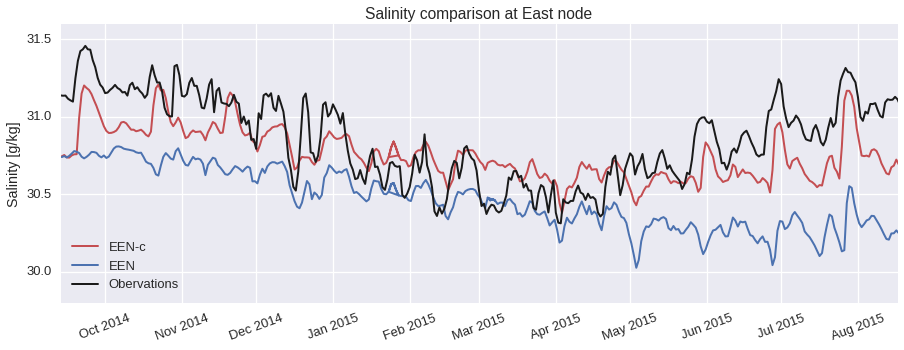

In [27]:
station='East node' 
fig,ax=plt.subplots(1,1,figsize= (15,5))
ax.plot(time_holl[station], teos_tools.psu_teos(sal_holl[station]), color='r', label='EEN-c',lw=2)
ax.plot(time_base[station], teos_tools.psu_teos(sal_base[station]), color='b', label='EEN', lw=2)
ax.plot(East_daily.date[:], teos_tools.psu_teos(East_daily['sal'][:]), color='k', label='Obervations', lw=2)
ax.set_xlim(datetime.datetime(2014,9,13),datetime.datetime(2015,8,17))
ax.set_ylabel('Salinity [g/kg]')
plt.setp( ax.xaxis.get_majorticklabels(), rotation=20)
ax.legend(loc=0)
ax.set_title('Salinity comparison at East node')

In [28]:

fig.savefig('/home/nsoontie/Desktop/East_hollbasespin.png', dpi=300, bbox_inches='tight')